In [23]:
# Env: rive
# Audrey / Cindy /
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)
import calendar
import os
import tensorflow as tf # Machine learning

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError
import tensorflow.keras.backend as K
import pandas as pd
import numpy as np

# Chargement des librairies + données
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [36]:
cible = "turb"

echantillons = pd.read_csv("../AtlasDeLEau/qualite_eau_complet.csv", dtype={'no_labo': 'string', 'no_station': 'string'})

qualite_eau = echantillons.copy()
qualite_eau['annee'] = pd.to_datetime(qualite_eau['date']).dt.year
qualite_eau['mois'] = pd.to_datetime(qualite_eau['date']).dt.month
qualite_eau = qualite_eau[(qualite_eau['mois'] >= 6) & (qualite_eau['mois'] <= 9) & (qualite_eau['annee'] >= 2016)]
qualite_eau['ID'] = qualite_eau['no_station'].astype(str) + "_" + qualite_eau['annee'].astype(str)
qualite_eau['nom_fichier'] = qualite_eau['ID'] + ".png"
qualite_eau = qualite_eau.dropna(subset=[cible])
qualite_eau[cible] = StandardScaler().fit_transform(qualite_eau[[cible]])

In [37]:
qualite_eau[cible]

19812    -0.224416
19813     0.038005
19814     0.084044
19819     0.130083
19820     1.373133
            ...   
132713    0.222161
132714    0.038005
132717    0.820666
132718    0.728589
132719   -0.026449
Name: turb, Length: 9372, dtype: float64

In [38]:
qualite_eau

,no_labo,no_projet,no_station,date,heure,alc,cat,cf,chl_aa,clo,...,AS (mg/l),PHE (µg/l),TAN (mg/l),AG (mg/l),U (mg/l),P-T-66V (µg/l),annee,mois,ID,nom_fichier
19812,Q111972-99,210,06130005,2019-06-10T00:00:00Z,1000,NaN,18.0,3.0,4.73,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019,6,06130005_2019,06130005_2019.png
19813,Q113254-06,210,06130005,2019-07-15T00:00:00Z,1010,NaN,27.0,5.0,4.51,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019,7,06130005_2019,06130005_2019.png
19814,Q114228-99,210,06130005,2019-08-06T00:00:00Z,950,NaN,27.0,52.0,3.17,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019,8,06130005_2019,06130005_2019.png
19819,Q120460-13,210,06130005,2020-07-13T00:00:00Z,1015,NaN,26.0,52.0,4.58,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020,7,06130005_2020,06130005_2020.png
19820,Q122442-21,210,06130005,2020-09-14T00:00:00Z,700,NaN,27.0,84.0,4.58,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020,9,06130005_2020,06130005_2020.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132713,Q114611-97,210,07710001,2019-08-13T00:00:00Z,912,NaN,15.0,430.0,2.28,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019,8,07710001_2019,07710001_2019.png
132714,Q115919-20,210,07710001,2019-09-18T00:00:00Z,845,NaN,17.0,54.0,2.06,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019,9,07710001_2019,07710001_2019.png
132717,Q120594-63,210,07710001,2020-07-14T00:00:00Z,1326,NaN,10.0,260.0,1.98,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020,7,07710001_2020,07710001_2020.png
132718,Q121526-38,210,07710001,2020-08-11T00:00:00Z,1627,NaN,12.0,900.0,1.60,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020,8,07710001_2020,07710001_2020.png


In [39]:
# Préparation des générateurs d'images
dossier_images = "../Imagerie/3km/"
colonne_noms_fichiers = "nom_fichier"
rescale_factor = 1/255
validation_fraction = 0.2
image_dimensions = (294, 201)
random_seed = int(np.round(np.random.uniform(0, 10000)))

train_data, val_data = train_test_split(qualite_eau, test_size=validation_fraction, random_state=random_seed)

In [40]:
train_data

,no_labo,no_projet,no_station,date,heure,alc,cat,cf,chl_aa,clo,...,AS (mg/l),PHE (µg/l),TAN (mg/l),AG (mg/l),U (mg/l),P-T-66V (µg/l),annee,mois,ID,nom_fichier
122156,Q088791-53,210,05020006,2016-06-13T00:00:00Z,1000,NaN,NaN,500.0,2.74,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2016,6,05020006_2016,05020006_2016.png
65544,Q112039-18,210,05240001,2019-06-11T00:00:00Z,1231,NaN,16.0,210.0,17.30,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019,6,05240001_2019,05240001_2019.png
21676,Q096276-69,210,04440002,2017-06-12T00:00:00Z,920,NaN,NaN,62.0,1.35,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2017,6,04440002_2017,04440002_2017.png
132442,Q106307-74,210,05040007,2018-08-14T00:00:00Z,900,NaN,NaN,150.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2018,8,05040007_2018,05040007_2018.png
99726,Q098941-27,210,03010012,2017-09-05T00:00:00Z,845,NaN,NaN,310.0,1.65,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2017,9,03010012_2017,03010012_2017.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127510,Q106325-12,210,05040006,2018-08-14T00:00:00Z,1215,NaN,NaN,100.0,1.71,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2018,8,05040006_2018,05040006_2018.png
99613,Q103845-08,230,03030323,2018-06-05T00:00:00Z,1800,NaN,NaN,1600.0,1.61,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2018,6,03030323_2018,03030323_2018.png
102194,Q091381-25,210,02250002,2016-09-07T00:00:00Z,1200,NaN,NaN,7.0,1.29,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2016,9,02250002_2016,02250002_2016.png
66061,Q111677-48,210,03020035,2019-06-03T00:00:00Z,1155,NaN,14.0,2400.0,5.34,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019,6,03020035_2019,03020035_2019.png


In [41]:
val_data

,no_labo,no_projet,no_station,date,heure,alc,cat,cf,chl_aa,clo,...,AS (mg/l),PHE (µg/l),TAN (mg/l),AG (mg/l),U (mg/l),P-T-66V (µg/l),annee,mois,ID,nom_fichier
130247,Q096342-20,210,07050001,2017-06-13T00:00:00Z,900,NaN,NaN,20.0,1.07,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2017,6,07050001_2017,07050001_2017.png
123759,Q090669-05,210,03040109,2016-08-10T00:00:00Z,1452,NaN,NaN,5.0,4.81,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2016,8,03040109_2016,03040109_2016.png
128196,Q098941-26,210,02E90001,2017-09-05T00:00:00Z,930,NaN,NaN,210.0,3.54,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2017,9,02E90001_2017,02E90001_2017.png
122703,Q088893-40,210,07040001,2016-06-14T00:00:00Z,1010,NaN,NaN,13.0,0.76,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2016,6,07040001_2016,07040001_2016.png
130090,Q111820-99,210,06240001,2019-06-04T00:00:00Z,1315,NaN,6.2,46.0,2.44,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019,6,06240001_2019,06240001_2019.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61914,Q089482-56,210,03010046,2016-07-05T00:00:00Z,1030,NaN,NaN,82.0,4.34,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2016,7,03010046_2016,03010046_2016.png
20538,Q122274-25,210,02500002,2020-09-08T00:00:00Z,1811,NaN,37.0,76.0,2.27,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020,9,02500002_2020,02500002_2020.png
132373,Q114448-02,230,05080100,2019-08-12T00:00:00Z,835,NaN,NaN,600.0,1.24,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019,8,05080100_2019,05080100_2019.png
94782,Q089645-34,210,05390001,2016-07-11T00:00:00Z,1130,NaN,NaN,530.0,2.07,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2016,7,05390001_2016,05390001_2016.png


In [42]:
datagen = ImageDataGenerator(rescale=rescale_factor)

training_generator = datagen.flow_from_dataframe(
    train_data,
    directory=dossier_images,
    x_col=colonne_noms_fichiers,
    y_col=cible,
    target_size=image_dimensions,
    class_mode="other",
    seed=random_seed
)

validation_generator = datagen.flow_from_dataframe(
    val_data,
    directory=dossier_images,
    x_col=colonne_noms_fichiers,
    y_col=cible,
    target_size=image_dimensions,
    class_mode="other",
    seed=random_seed
)

Found 7497 validated image filenames.
Found 1875 validated image filenames.


In [43]:
# Préparation et ajustement du modèle
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(image_dimensions[0], image_dimensions[1], 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, kernel_size=(3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(512, kernel_size=(3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation="relu"),
    Dense(1)
])

def r2(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

model.summary()

In [44]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae", r2])

In [45]:

# Exploration des résultats
history = model.fit(
    x=training_generator,
    validation_data=validation_generator,
    epochs=20
)

Epoch 1/20
235/235 [==============================] - 580s 2s/step - loss: 1.0808 - mae: 0.4609 - r2: -0.1208 - val_loss: 0.6814 - val_mae: 0.4314 - val_r2: -0.1392
Epoch 2/20
235/235 [==============================] - 528s 2s/step - loss: 1.0799 - mae: 0.4644 - r2: -0.1350 - val_loss: 0.6810 - val_mae: 0.4236 - val_r2: -0.1361
Epoch 3/20
173/235 [=====================>........] - ETA: 2:24 - loss: 1.2652 - mae: 0.4715 - r2: -0.0941

KeyboardInterrupt: 

In [ ]:
history.history

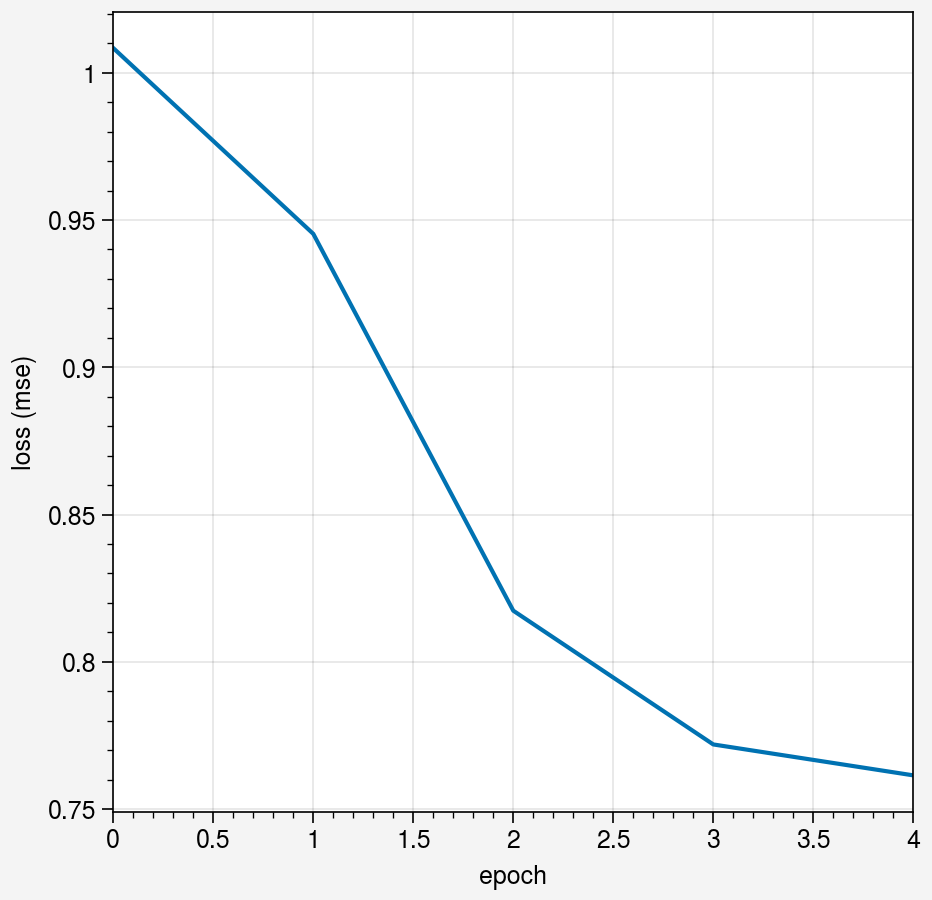

In [15]:
fig, axs = pplt.subplots(ncols=2, nrows=1, refwidth=4)

axs[0].plot(history.history['loss'], label='training')
axs[0].plot(history.history['val_loss'], label='validation')
axs[0].format(xlabel='Epoch', ylabel='Loss (MSE)')

axs[1].plot(history.history['r2'], label='training')
axs[1].plot(history.history['val_r2'], label='validation')
axs[1].format(xlabel='Epoch', ylabel='$r^2$')

In [ ]:
file_pi = 'qualite_eau_M0_3km'

In [ ]:
with open('/trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi+'.pkl')

model.save_weights('weights/'+file_pi+'.h5')

In [ ]:
with open('/trainHistoryDict', "rb") as file_pi:
    history = pickle.load(file_pi+'.pkl')

model.load_weights('weights/'+file_pi+'.h5')